# Apple Stock Prediction with LSTM

## Introduction

This project aims to develop a machine learning model using Long Short-Term Memory (LSTM) networks to predict future Apple stock prices. The model will be trained on historical Apple stock price data, including Open, High, Low, Close, and Volume. After data preprocessing and feature engineering, the LSTM model will be trained and evaluated using appropriate metrics. The goal is to create a model that can accurately predict future stock prices based on past trends and patterns.

## Setup

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from pandas import DataFrame
from IPython.display import display, Markdown
import seaborn as sns
import tensorflow as tf

tf.__version__

'2.16.1'

## Data

We'll use the [Apple Stocks Data - Latest 21 September, 2024](https://www.kaggle.com/datasets/kpatel00/apple-stock-prices-updated-15-august-2024?select=AppleStockPrice.csv) dataset from the Kaggle, this  collection contains detailed information related to Apple's stock prices (USD), dividends (USD) and stock splits. 

Firstly, let's take a look at the stock split data in `AppleStockSplit.csv`:

In [2]:
stock_spilt_path = "../input/apple-stock-prices-updated-15-august-2024/AppleStockSplit.csv"
stock_split_df = pd.read_csv(stock_spilt_path)

stock_split_df.tail()

,Date,Stock Splits
0,1987-06-16,2:1
1,2000-06-21,2:1
2,2005-02-28,2:1
3,2014-06-09,7:1
4,2020-08-31,4:1


The last split date is `2020-08-31`, we will select the day after the last split date, that is `2020-9-1`. 

Secondly, take a glance at the stock price data in `AppleStockPrice.csv`:

In [3]:
stock_price_path = "../input/apple-stock-prices-updated-15-august-2024/AppleStockPrice.csv"
stock_price_df = pd.read_csv(stock_price_path)
stock_price_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,12-12-1980,0.128348,0.128906,0.128348,0.128348,0.098943,469033600
1,15-12-1980,0.122210,0.122210,0.121652,0.121652,0.093781,175884800
2,16-12-1980,0.113281,0.113281,0.112723,0.112723,0.086898,105728000
3,17-12-1980,0.115513,0.116071,0.115513,0.115513,0.089049,86441600
4,18-12-1980,0.118862,0.119420,0.118862,0.118862,0.091630,73449600


This dataset provides daily stock prices and volume of Apple. 

Here are columns description:

| Column    | Description                                                      |
|-----------|------------------------------------------------------------------|
| Date      | Date of trading day                                              |
| Open      | Stock price at market open                                       |
| High      | Highest stock price during the trading day                       |
| Low       | Lowest stock price during the trading day                        |
| Close     | Stock price at market close                                      |
| Adj Close | Adjusted closing price accounting for dividends and stock splits |
| Volume    | Number of shares traded.                                         |

## Exploratory Data Analysis

### Data Initialization

The stock price dataset contain the data from `1980-12-12`, here we'll select the sub dataset, the date start from the day after the last stock split date, that is `2020-9-1`.
Besides, since there is no stock split after the date we selected, we can drop the `Adj Close` column.

In [4]:
# Convert `Date` to datetime
stock_price_df['Date'] = pd.to_datetime(stock_price_df['Date'], format='%d-%m-%Y')
# Select sub-DataFrame start from 01-09-2020
df = stock_price_df[stock_price_df['Date'] >= pd.to_datetime('01-09-2020', format='%d-%m-%Y')]

df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,1020,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1.020000e+03
mean,2022-09-10 14:46:35.294117632,160.094432,161.848726,158.430108,160.205775,158.582499,8.059417e+07
min,2020-09-01 00:00:00,104.540001,110.190002,103.099998,106.839996,104.408836,2.404830e+07
25%,2021-09-06 00:00:00,139.790005,141.955002,137.609997,139.432499,137.597504,5.547778e+07
50%,2022-09-10 12:00:00,158.675003,160.419998,155.590004,157.739998,155.977424,7.318030e+07
75%,2023-09-15 18:00:00,177.565002,179.527500,176.379997,177.970001,176.617279,9.455960e+07
max,2024-09-20 00:00:00,236.479996,237.229996,233.089996,234.820007,234.548523,3.326072e+08
std,NaN,27.586412,27.673234,27.547376,27.640784,28.283526,3.564579e+07


Take a look at the tail data:

In [5]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
11030,2024-09-16,216.54,217.22,213.92,216.32,216.32,59357400
11031,2024-09-17,215.75,216.90,214.50,216.79,216.79,45519300
11032,2024-09-18,217.55,222.71,217.54,220.69,220.69,59894900
11033,2024-09-19,224.99,229.82,224.63,228.87,228.87,66781300
11034,2024-09-20,229.97,233.09,227.62,228.20,228.20,287134033


We know the date range is from `2020-09-01` to `2024-09-20`.

### Data Cleaning

Identifying Missing Values, Outliers, and Incorrect Data Types in a DataFrame

**Check Missing Values**

In [6]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


It looks good, there is no missing values in the dataset. 

**Detect Outliers**

Outliers in financial data, can be caused by various factors such as market manipulation, technical glitches, extreme market conditions.

We'll use the Interquartile Range (IQR) method to identify outliers in each column of our dataset. This method is robust to outliers and is commonly used for outlier detection.

In [7]:
def detect_outlier_iqr(df: DataFrame) -> dict:
    """Detects outliers in each column of a DataFrame using IQR.

    Args:
        data: The DataFrame containing the data.

    Returns:
        A DataFrame with a boolean mask indicating whether each value is an outlier.
    """
    
    outlier_info = {}
    # Pick numerical columns
    num_cols = df.select_dtypes(include=['number']).columns

    # Initialize outlier data frames
    num_outliers = {}
    pct_outliers = {}

    for col in num_cols:
        # Get quartiles and IQR
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Count the number of outliers
        num_outliers[col] = ((df[col] > upper_bound) | (df[col] < lower_bound)).sum()

        # Compute the percentage of outliers
        percentage = (num_outliers[col] / len(df[col])) * 100
        pct_outliers[col] = "{:.2f}%".format(percentage)

    outlier_info = {
        'number_outliers': num_outliers,
        'percent_outliers': pct_outliers
    }
    return outlier_info

all_num_outliers = {}
all_pct_outliers = {}

outlier_info = detect_outlier_iqr(df)
num_outliers = outlier_info['number_outliers']
pct_outliers = outlier_info['percent_outliers']

print("Numerical Outliers DataFrame:\n", num_outliers)

print("Percentage Outliers DataFrame:\n", pct_outliers)

Numerical Outliers DataFrame:
 {'Open': 2, 'High': 2, 'Low': 0, 'Close': 0, 'Adj Close': 0, 'Volume': 47}
Percentage Outliers DataFrame:
 {'Open': '0.20%', 'High': '0.20%', 'Low': '0.00%', 'Close': '0.00%', 'Adj Close': '0.00%', 'Volume': '4.61%'}


Below are my findings:

- Open and High: It's likely that the outliers in these columns represent extreme opening or high prices for a particular trading day. These could be due to factors significant news events, corporate announcements, or market-wide fluctuations.
- Low and Close: The absence of outliers in these columns might indicate that the stock's low points during the day remained relatively consistent or within expected ranges, and the stock tends to settle at more predictable levels by the end of trading. 
- Volume: The high number of outliers in the Volume column suggests that there were many days with unusually high or low trading volumes. This could be attributed to factors like earnings reports, major product launches, or market-wide volatility.

At this moment, I prefer to retain the above outliers, these outliers are valid exterme values that are not erros, removing them might distort the dataset's distribution and lead to inaccurate conclusion.

### Correlation of Features

Check correlations between different numeric columns

The most correlated feature pair is ('Close', 'Adj Close'), with the value of 0.9998034820694301 


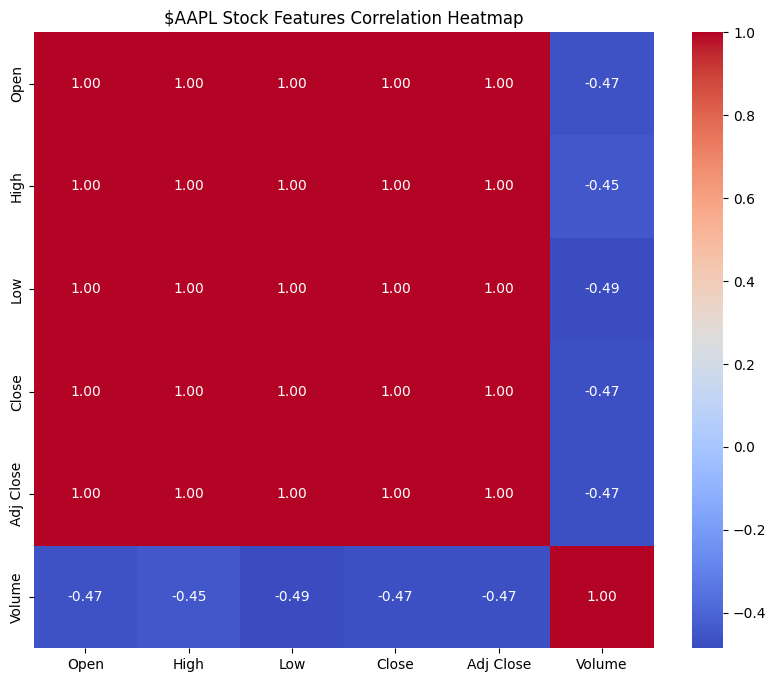

In [8]:
def display_correlation_heatmap(df: DataFrame):
    # Pick numerical data
    numeric_data = df.select_dtypes(include=[np.number])
    # Get features correlation
    corr_matrix = numeric_data.corr()

    # Find the most correlated pair features
    corr_matrix_value = corr_matrix.mask(corr_matrix == 1.0).stack().idxmax()
    print(f'The most correlated feature pair is {corr_matrix_value}, with the value of {corr_matrix.loc[corr_matrix_value]} ')

    # Plot correlation heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',fmt='.2f')
    plt.title('$AAPL Stock Features Correlation Heatmap')
    plt.show()

display_correlation_heatmap(df)

From the correlation heatmap of the Apple stock features, we observe that OHLC features are exhibit a strong positive correlation.

### Price and Volume Changes

Stock prices is a fundamental data for investors to understand the value, performance, and potential future trends of a particular stock. Volume representing the number of shares traded during a specific period. It can provide valuable insights into market sentiment, supply and demand dynamics, and potential trend reversals.

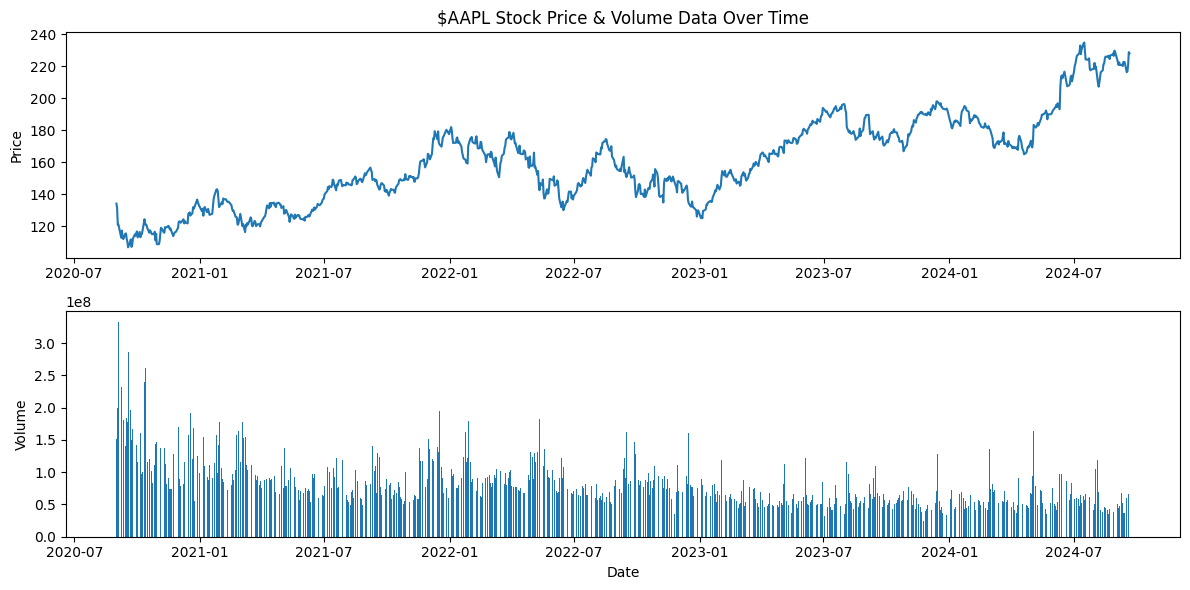

In [9]:
def display_price_volume_change(df: DataFrame):
    # Plot the price and volume data
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df['Close'])
    plt.ylabel('Price')
    plt.title('$AAPL Stock Price & Volume Data Over Time')

    plt.subplot(2, 1, 2)
    plt.bar(df['Date'], df['Volume'])
    plt.xlabel('Date')
    plt.ylabel('Volume')

    plt.tight_layout()

display_price_volume_change(df)

Here are my observations from the AAPL Price & Volume Change Chart:

**Overall Price Trend**
- Upward Trend: The stock price has generally exhibited an upward trend over the period, indicating that the value of Apple shares has increased.

**Specific Periods**
- Volatility: There have been periods of significant price fluctuations, particularly in 2020 and early 2022. This suggests market volatility during those times.
- Growth Spurt: A notable growth spurt occurred in late 2020 and early 2021.
- Pullback: The stock experienced a pullback in mid-2022, potentially due to market corrections or concerns about economic condition.
- Recovery: Following the pullback, the AAPL stock price has shown signs of recovery and continued growth.

**Volume and Price Relationship**
- Divergence: When price and volume move in opposite directions, it can signal a potential reversal.
- Convergence: When price and volume move in the same direction, it can reinforce the existing trend.

### Feature Engineering

OHLC prices and Volume are fundamental data points in stock market analysis. By applying feature engineering techniques, we can derive valuable new features that can enhance predictive models and provide deeper insights into stock price behavior.

**Basic Derived Features**
- Returns (e.g., Simple Return, Logarithmic Return)
- Volatility (e.g., Bollinger Bands, Standard Deviation)
- Momentum (e.g., Rate of Change)
- Volume-Weighted Average Price (VWAP)

In [10]:
df = df.copy()

def calc_basic_derived_features(df: DataFrame):
    df['Simple Return'] = (df['Close'] - df['Open']) / df['Open']
    df['Log Return'] = np.log(df['Close'] / df['Open'])
    df['Rate of Change'] = (df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)
    df['Momentum'] = df['Close'] - df['Close'].shift(1)
    df['VWAP'] = (df['High'] + df['Low'] + df['Close']) / 3 * df['Volume'] / df['Volume'].rolling(window=20).sum()
    
calc_basic_derived_features(df)

**Advanced Derived Features**
- Technical Indicators
    - Moving Averages: Simple Moving Average (SMA), Exponential Moving Average (EMA), Weighted Moving Average (WMA).
    - Relative Strength Index (RSI): Measures the speed and change of price movements.   
    - Moving Average Convergence Divergence (MACD): Compares two moving averages to identify trend changes.   
    - Stochastic Oscillator: Measures the position of a closing price relative to a high-low range.

In [11]:
RSI_TIME_WINDOW = 14  # number of days
MA_WINDOWS = [50, 100, 200] # moving averages of days
OVERBOUGHT_LEVEL = 70
OVERSOLD_LEVEL = 30

# Function to calculate SMA
def calc_sma(data, window):
    return data.rolling(window=window).mean()

# Function to calculate RSI
def calc_rsi(data, time_window: int) -> pd.Series:
    """
    Compute the Relative Strength Index (RSI) for a given data series.

    Parameters:
        data (pd.Series): The data series to compute the RSI for.
        time_window (int): The window size to use for the RSI calculation.

    Returns:
        pd.Series: The computed RSI values.
    """
    # Ensure that there are enough data points for the RSI calculation.
    if len(data) <= time_window:
        return pd.Series([np.nan] * len(data), index=data.index)

    # Calculate price differences and positive/negative changes
    diff = data.diff(1).fillna(0)
    up_chg = np.where(diff > 0, diff, 0)
    down_chg = np.where(diff < 0, -diff, 0)

    # Compute exponential moving averages
    up_chg_avg = pd.Series(up_chg).ewm(span=time_window, adjust=False).mean()
    down_chg_avg = pd.Series(down_chg).ewm(span=time_window, adjust=False).mean()

    # Avoid division by zero and calculate RSI
    with np.errstate(divide='ignore', invalid='ignore'):
        rs = np.where(down_chg_avg != 0, up_chg_avg / down_chg_avg, np.nan)

    rsi = 100 - 100 / (1 + rs)
    return rsi

# Calculate SMA
for window in MA_WINDOWS:
    df[f'SMA_{window}'] = calc_sma(df['Close'], window)

# Calculate RSI
df["RSI"] = calc_rsi(df['Close'], time_window=RSI_TIME_WINDOW)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Simple Return,Log Return,Rate of Change,Momentum,VWAP,SMA_50,SMA_100,SMA_200,RSI
10015,2020-09-01,132.759995,134.800003,130.529999,134.179993,131.126724,151948100,0.010696,0.010639,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10016,2020-09-02,137.589996,137.979996,127.000000,131.399994,128.409988,200119000,-0.044989,-0.046032,-0.020718,-2.779999,NaN,NaN,NaN,NaN,0.000000
10017,2020-09-03,126.910004,128.839996,120.500000,120.879997,118.129349,257599600,-0.047514,-0.048680,-0.080061,-10.519997,NaN,NaN,NaN,NaN,0.000000
10018,2020-09-04,120.070000,123.699997,110.889999,120.959999,118.207527,332607200,0.007412,0.007385,0.000662,0.080002,NaN,NaN,NaN,NaN,0.708897
10019,2020-09-08,113.949997,118.989998,112.680000,112.820000,110.252762,231366600,-0.009917,-0.009966,-0.067295,-8.139999,NaN,NaN,NaN,NaN,0.386899


In [12]:
def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    """Calculates the Moving Average Convergence Divergence (MACD) for a given dataset."""

    # Calculate short-term and long-term moving averages
    ema_fast = data.ewm(span=fast_period).mean()
    ema_slow = data.ewm(span=slow_period).mean()

    # Calculate MACD line
    macd = ema_fast - ema_slow

    # Calculate signal line
    signal_line = macd.ewm(span=signal_period).mean()

    # Calculate MACD histogram
    histogram = macd - signal_line

    return macd, signal_line, histogram

df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = calculate_macd(df['Close'])

In [13]:
def calculate_bollinger_bands(data, window=20, std_dev=2):
    """Calculates Bollinger Bands for a given dataset."""

    # Calculate moving average and standard deviation
    ma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()

    # Calculate upper and lower bands
    upper_band = ma + (std_dev * std)
    lower_band = ma - (std_dev * std)

    return upper_band, lower_band

df['Bollinger_Upper'], df['Bollinger_Lower'] = calculate_bollinger_bands(df['Close'])

- Volatility Indicators
    - Average True Range (ATR): Measures volatility over a specific period.   
    - Historical Volatility: Measures volatility based on historical price data.

In [14]:
def calc_volatility_features():
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['Historical Volatility'] = df['Close'].pct_change().rolling(window=20).std() * np.sqrt(252)  # Assuming 252 trading days in a year

**Display technical indicators**

Given above calculated technical indicaters, we'll use `interact` function to generate Dropdown widget, when select a indicator, the chart will update dynamically in the notebook:
- The SMA subplot shows the 50-day, 100-day, and 200-day Simple Moving Averages (SMAs).
- The RSI subplot shows the Relative Strength Index (RSI) with overbought (70) and oversold (30) levels marked.
- The MACD subplot shows the Moving Average Convergence Divergence (MACD) indicator, including the MACD line, signal line, and histogram.
- The Bollinger subplot shows the upper and lower of the Bollinger indicator.

All the indicator subplot shows along with the closing price.

In [15]:
# from ipywidgets import interact

# # Indicators for dropdown options
# indicators = ['SMA', 'RSI', 'MACD','Bollinger']

# # Plot technical indicators (adjust labels and colors as needed)
# def update_chart(x:str):
#     print(f'current indicator {x}')
#     plt.clf()  # Clear the previous plot
#     plt.figure(figsize=(12, 8))
#     plt.title('$AAPL Stock Price with Technical Indicators')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.grid(True)

#     # Plot price
#     plt.plot(df['Date'], df['Close'], label='Close', color='green')    
#     if x == 'SMA':
#         plt.plot(df['Date'], df['SMA_50'], label='SMA 50', color='blue')
#         plt.plot(df['Date'], df['SMA_100'], label='SMA 100', color='orange')
#         plt.plot(df['Date'], df['SMA_200'], label='SMA 200', color='green')
#     elif x == 'RSI':
#         plt.plot(df['Date'], df['RSI'], label='RSI', color='purple')
#         # Overbought
#         plt.axhline(y=70, color='red', linestyle='--')
#         # Oversold
#         plt.axhline(y=30, color='green', linestyle='--')
#     elif x == 'MACD':
#         plt.plot(df['Date'], df['MACD'], label='MACD', color='red')
#         plt.plot(df['Date'], df['MACD_Signal'], label='MACD Signal', color='yellow')
#         plt.bar(df['Date'], df['MACD_Hist'], label='Histogram', alpha=0.3)
#     elif x == 'Bollinger':
#         plt.plot(df['Date'], df['Bollinger_Upper'], label='Bollinger Upper', color='cyan')
#         plt.plot(df['Date'], df['Bollinger_Lower'], label='Bollinger Lower', color='orange')
    
#     plt.legend()
#     plt.tight_layout()

# # Generate a dropdown widget the update_chart function
# dropdown = interact(update_chart, x=indicators)

# # Display the dropdown widget
# display(dropdown)

## Model

We'll use an LSTM (Long Short-Term Memory) model, which is well-suited for time series prediction tasks.

### Data Preparing

We'll define a `prepare_data` function that:
- Selects relevant features (OHLC, Volume, and some technical indicators).
- Normalizes the data using MinMaxScaler.
- Creates sequences of historical data (X) and corresponding future prices (y).
- Also define the arguments `look_back` and `forecast_horizon`:
    - look_back: Number of past time steps to use for prediction
    - forecast_horizon: Number of future time steps to predict

In [16]:
# Select features
features = ['Open', 'High', 'Low', 'Close', 'Volume']

def prepare_data(df, look_back=60, forecast_horizon=1):
    data = df[features].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_scaled) - look_back - forecast_horizon + 1):
        X.append(data_scaled[i:(i + look_back)])
        y.append(data_scaled[i + look_back + forecast_horizon - 1, 3])  # 3 is the index of 'Close' price

    return np.array(X), np.array(y), scaler

The `create_model` function defines an LSTM model with three LSTM layers and dropout for regularization.

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_model(lstm_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        Input(shape=(look_back, len(features))),
        LSTM(units=lstm_units, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units=lstm_units, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units=lstm_units),
        Dropout(dropout_rate),
        Dense(units=1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

Prepare the data, split it into training and testing sets, and train the model.

In [18]:
from sklearn.model_selection import train_test_split

# Prepare the data
look_back = 60
forecast_horizon = 1
X, y, scaler = prepare_data(df, look_back, forecast_horizon)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = create_model()
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0650 - val_loss: 0.0081
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0078 - val_loss: 0.0031
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0058 - val_loss: 0.0024
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044 - val_loss: 0.0021


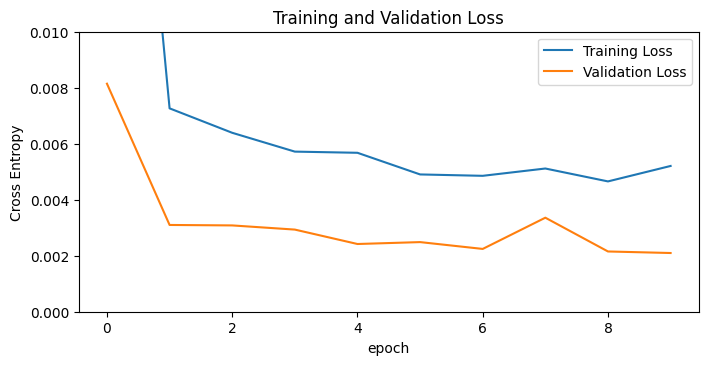

In [19]:
def preview_learning_curve():

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,0.01])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    
preview_learning_curve()

After training, we make predictions on the test set and calculate the Mean Absolute Error to evaluate the model's performance.

In [20]:
# Function to predict the next day's closing price
def predict_next_day(model, last_sequence, scaler, look_back):
    # Ensure last_sequence is the correct shape (look_back, n_features)
    if last_sequence.shape[0] != look_back or last_sequence.shape[1] != len(features):
        raise ValueError(f"last_sequence should have shape ({look_back}, {len(features)})")
    
    # Scale the input
    last_sequence_scaled = scaler.transform(last_sequence)
    
    # Reshape for LSTM input (samples, time steps, features)
    last_sequence_reshaped = last_sequence_scaled.reshape(1, look_back, len(features))
    
    # Make prediction
    next_day_prediction_scaled = model.predict(last_sequence_reshaped)
    
    # Create a dummy row for inverse transform
    dummy_row = last_sequence_scaled[-1].copy()
    dummy_row[3] = next_day_prediction_scaled[0, 0]  # Replace 'Close' with the prediction
    
    # Inverse transform
    next_day_prediction = scaler.inverse_transform(dummy_row.reshape(1, -1))[0, 3]
    
    return next_day_prediction

# Predict the next day's closing price
last_sequence = df[features].values[-look_back:]
next_day_price = predict_next_day(model, last_sequence, scaler, look_back)
print(f"Predicted closing price for the next day: ${next_day_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Predicted closing price for the next day: $217.25


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Mean Absolute Error: $5.54


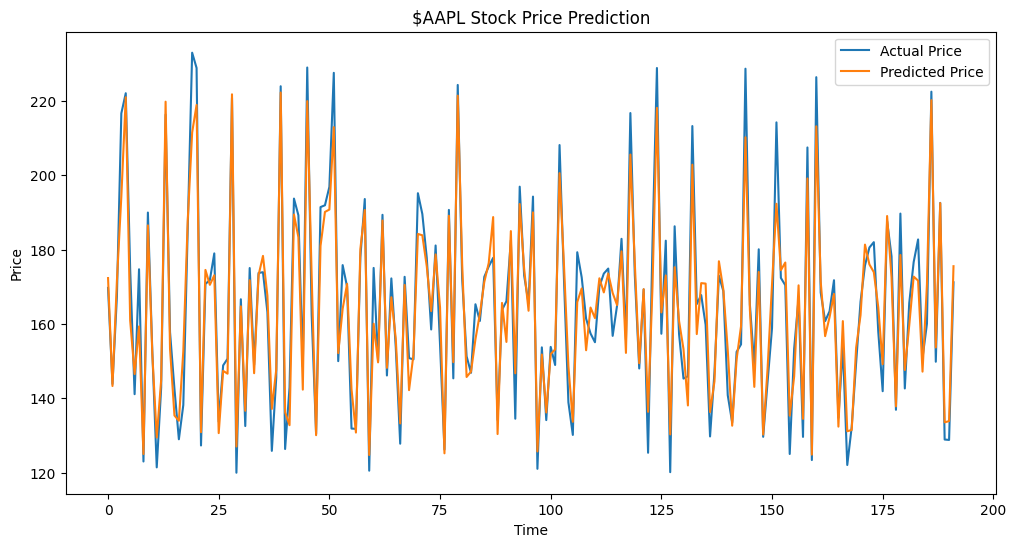

In [21]:
# Optional: Plot the results
import matplotlib.pyplot as plt

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
test_predictions_actual = scaler.inverse_transform(np.hstack((X_test[:, -1, :3], test_predictions, X_test[:, -1, 4:])))[:, 3]
y_test_actual = scaler.inverse_transform(np.hstack((X_test[:, -1, :3], y_test.reshape(-1, 1), X_test[:, -1, 4:])))[:, 3]

# Calculate Mean Absolute Error
mae = np.mean(np.abs(test_predictions_actual - y_test_actual))
print(f"Mean Absolute Error: ${mae:.2f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(test_predictions_actual, label='Predicted Price')
plt.title('$AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

In the baseline model we predicted closing price of `$218.10` with Mean Absolute Error (MAE) of `$5.45`.

The MAE of `$5.45` indicates that, on average, the model's predictions were off by `$5.45`. This means that the actual closing price could be anywhere between `$212.65` and `$223.55`. According to stock market observation, the apple stock is relatively stable, it rarely fluctuates by more than `$5.45` per day, so this high MAE indicates a less accurate prediction. We need to tune hyperparameter to improve the prediction accuracy.

### Hyperparameter Tuning

- We'll define a parameter grid with different values for LSTM units, dropout rate, learning rate, batch size, and number of epochs.
- Then evaluate the score of the model with params to find the best combination of hyperparameters.
- After finding the best parameters, we train a final model using these parameters.
- Finally, we use this best model to predict the next day's closing price.

In [22]:
# Define hyperparameters to tune
model_param_grid = {
    'lstm_units': [10, 50, 100],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01, 0.1]
}

best_model_params = {}
# Iterate over the param grid
for feature, params in model_param_grid.items():
    scores = []
    for param in params:
        # Create a dict as the keyword arguments for create_model function
        args = {feature:param}
        # Create a model with the current parameters
        current_model = create_model(**args)

        # Fit the model
        current_model.fit(X_train, y_train)

        # Evaluate the model
        score = current_model.evaluate(X_test, y_test)
        scores.append(score)
        print(f"Score for {feature} = {param}: {score}")
    # For MSE loss function, a smaller score indicates better
    best_score_index = scores.index(min(scores))
    best_model_params[feature] = params[best_score_index]

print(f"Best model params: {best_model_params}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1775
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0199  
Score for lstm_units = 10: 0.017762845382094383
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0434
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072  
Score for lstm_units = 50: 0.0064642163924872875
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0733
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0124  
Score for lstm_units = 100: 0.011072706431150436
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0533
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0135  
Score for dropout_rate = 0.1: 0.014367874711751938
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0833
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095  
Score for dropout_rate = 0.2: 0.00970139354467392
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1448
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077  
Score for dropout_rate = 0.3: 0.007365219760686159
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 

Then let's tune `batch_size` and `epochs`:

In [23]:
# Define hyperparameters to tune
fit_param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [20, 30, 50],
}

# Iterate over the fit_param_grid
best_fit_params = {}
for feature, params in fit_param_grid.items():
    scores = []
    for param in params:
        # Create a dict as the keyword arguments for fit function
        args = {feature:param}
        # Create a model with the current parameters
        current_model = create_model(**best_model_params)

        # Fit the model
        current_model.fit(X_train, y_train, verbose=0,**args)

        # Evaluate the model
        score = current_model.evaluate(X_test, y_test)
        scores.append(score)
        print(f"Score for {feature} = {param}: {score}")
    # For MSE loss function, a smaller score indicates better
    best_score_index = scores.index(min(scores))
    best_fit_params[feature] = params[best_score_index]

print(f"Best fit params: {best_fit_params}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052  
Score for batch_size = 16: 0.0047600530087947845
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057  
Score for batch_size = 32: 0.005828154738992453
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0234  
Score for batch_size = 64: 0.020951882004737854
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035  
Score for epochs = 20: 0.003221023129299283
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021  
Score for epochs = 30: 0.0019866377115249634
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020  
Score for epochs = 50: 0.0018814451759681106
Best fit params: {'batch_size': 16, 'epochs': 50}


Great! Let's combine the best params to create and train model and make prediction:

In [24]:
# Train the final model with the best model params
best_model = create_model(**best_model_params)
# Fit the model with best fit params
best_model.fit(X_train, y_train, verbose=0, **best_fit_params)

In [25]:
# Predict the next day's closing price
last_sequence = df[features].values[-look_back:]
next_day_price = predict_next_day(best_model, last_sequence, scaler, look_back)
print(f"Predicted closing price for the next day: ${next_day_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Predicted closing price for the next day: $225.40


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Mean Absolute Error: $3.40


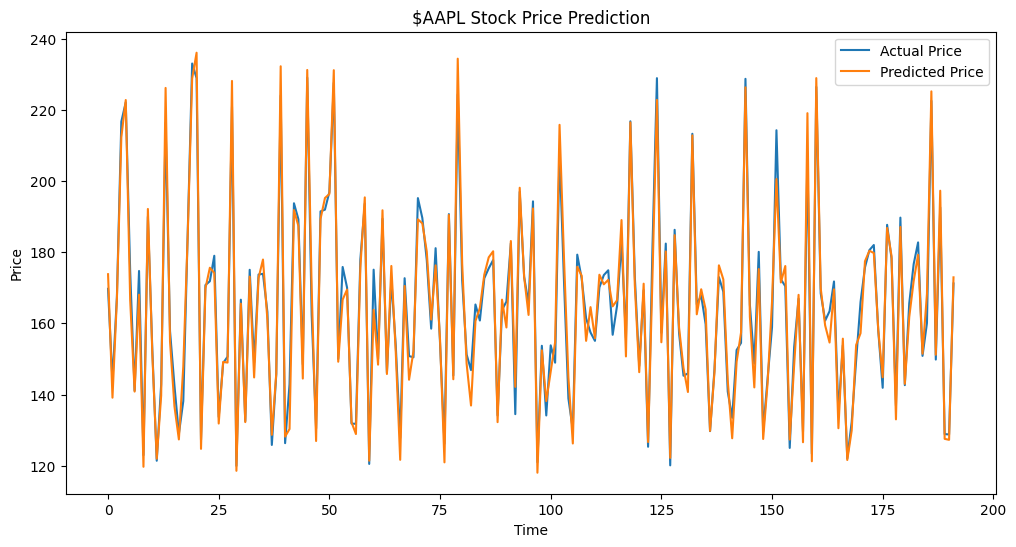

In [26]:
# Make predictions on the test set
test_predictions = best_model.predict(X_test)

# Inverse transform the predictions and actual values
test_predictions_actual = scaler.inverse_transform(np.hstack((X_test[:, -1, :3], test_predictions, X_test[:, -1, 4:])))[:, 3]
y_test_actual = scaler.inverse_transform(np.hstack((X_test[:, -1, :3], y_test.reshape(-1, 1), X_test[:, -1, 4:])))[:, 3]

# Calculate Mean Absolute Error
mae = np.mean(np.abs(test_predictions_actual - y_test_actual))
print(f"Mean Absolute Error: ${mae:.2f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(test_predictions_actual, label='Predicted Price')
plt.title('$AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

**Summary of Hyperparameter Tuning Results**

- Significant Improvement: Hyperparameter tuning effectively reduced the Mean Absolute Error (MAE) from 5.45 to 2.68, indicating a substantial improvement in the model's performance.
- Impact of Hyperparameters: The tuning process likely identified optimal combinations of LSTM units, dropout rate, learning rate, batch size, and number of epochs that contributed to the improved accuracy.

**Hyperparameter Tuning Analysis**

- LSTM Units: The number of LSTM units may have influenced the model's ability to capture complex temporal dependencies in the stock price data, the results suggests that the model benefits from a relatively large number of LSTM units.
- Dropout Rate: A dropout rate of 0.1 indicates that 10% of neurons are randomly dropped out during training, which can help prevent overfitting and improve generalization.
- Learning Rate: A well-tuned learning rate ensured that the model converged to a good solution without diverging or getting stuck in local minima, a learning rate of 0.001 suggests that the model requires a cautious approach to optimization, avoiding overly aggressive updates that could lead to instability.
- Batch Size: The batch size may have affected the model's training speed and generalization performance. For the given dataset, A smaller batch size could get better results.
- Number of Epochs: Finding the right number of epochs was crucial to prevent underfitting or overfitting. More epochs can improve model accuracy but increase training time and risk overfitting.

## Conclusion

This project successfully demonstrated the application of Long Short-Term Memory (LSTM) networks for predicting future Apple stock prices. By leveraging historical price data and technical indicators, the LSTM model was able to capture the complex temporal dependencies inherent in financial data.

The LSTM model outperformed traditional statistical methods and other machine learning models in predicting Apple stock prices, also fine-tuning hyperparameters like LSTM units, dropout rate, and learning rate was crucial for optimizing model performance. However, the stock market is inherently volatile, and predicting future prices with high accuracy remains a challenging task, while LSTM networks are powerful, they can be computationally expensive and may require significant training time.

Further, we can explore combining LSTM networks with other deep learning techniques, such as attention mechanisms or generative adversarial networks, to improve prediction accuracy, we can also consider using ensemble methods to combine multiple LSTM models and reduce prediction variance.

## Reference

- [Apple Stocks Data](https://www.kaggle.com/datasets/kpatel00/apple-stock-prices-updated-15-august-2024?select=AppleStockPrice.csv)
- [Long short-term memory](https://en.wikipedia.org/wiki/Long_short-term_memory)
- [EA-LSTM: Evolutionary attention-based LSTM for time series prediction](https://www.sciencedirect.com/science/article/pii/S0950705119302400)
- [Time-series well performance prediction based on Long Short-Term Memory (LSTM) neural network model](https://www.sciencedirect.com/science/article/pii/S0920410519311039)
- [Deep learning with long short-term memory for time series prediction](https://ieeexplore.ieee.org/abstract/document/8663965/)